Random Forest with 6 features  
Changing via loop:
* max depth
* min leaf
* num trees 

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.tree import plot_tree, DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

In [48]:
# Load files into a pandas dataframe
df = pd.read_csv('data/Train.csv')
# Let’s observe the shape of our datasets.
print('train data shape :', df.shape)
# inspect train data
df.head()

train data shape : (23524, 13)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [49]:
# drop columns I don't need for my model
df.drop('year', axis=1, inplace=True)
df.drop('uniqueid', axis=1, inplace=True)
df.head()

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   bank_account            23524 non-null  object
 2   location_type           23524 non-null  object
 3   cellphone_access        23524 non-null  object
 4   household_size          23524 non-null  int64 
 5   age_of_respondent       23524 non-null  int64 
 6   gender_of_respondent    23524 non-null  object
 7   relationship_with_head  23524 non-null  object
 8   marital_status          23524 non-null  object
 9   education_level         23524 non-null  object
 10  job_type                23524 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.0+ MB


In [51]:
df['bank_account'] = df['bank_account'].map({'No': 0, 'Yes': 1})
df['location_type'] = df['location_type'].map({'Rural': 0, 'Urban': 1})
df.columns = df.columns.str.replace('location_type','Urban_location')
df['cellphone_access'] = df['cellphone_access'].map({'No': 0, 'Yes': 1})
df['gender_of_respondent'] = df['gender_of_respondent'].map({'Male': 0, 'Female': 1})

df['country'] =  df['country'].map({'Kenya':0, 'Rwanda':1, 'Tanzania':2, 'Uganda':3})

df['relationship_with_head']=df['relationship_with_head'].map({'Spouse':0,
                                                            'Head of Household':1,
                                                            'Other relative':2,
                                                            'Child':3,
                                                            'Parent':4,
                                                            'Other non-relatives':5})

df['marital_status'] =df['marital_status'].map({'Married/Living together':0,
                                                'Widowed':1,
                                                'Single/Never Married':2,
                                                'Divorced/Seperated':3,
                                                'Dont know':4})


df['education_level'] = df['education_level'].map({'Secondary education':0,
                                                   'No formal education':1,
                                                   'Vocational/Specialised training':2,
                                                   'Primary education':3,
                                                   'Tertiary education':4,
                                                   'Other/Dont know/RTA':5
                                                   }) 
  
df['job_type'] = df['job_type'].map({'Self employed':0,
                                     'Government Dependent':1,
                                     'Formally employed Private':2,
                                     'Informally employed':3,
                                     'Formally employed Government':4,
                                     'Farming and Fishing':5,
                                     'Remittance Dependent':6,
                                     'Other Income':7,
                                     'Dont Know/Refuse to answer':8,
                                     'No Income':9
                                     })

In [52]:
df[['country', 'bank_account', 'Urban_location', 'cellphone_access', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level','job_type']] = df[['country', 
                                                                                        'bank_account', 
                                                                                        'Urban_location', 
                                                                                        'cellphone_access', 
                                                                                        'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level','job_type']].astype('category')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 23524 non-null  category
 1   bank_account            23524 non-null  category
 2   Urban_location          23524 non-null  category
 3   cellphone_access        23524 non-null  category
 4   household_size          23524 non-null  int64   
 5   age_of_respondent       23524 non-null  int64   
 6   gender_of_respondent    23524 non-null  category
 7   relationship_with_head  23524 non-null  category
 8   marital_status          23524 non-null  category
 9   education_level         23524 non-null  category
 10  job_type                23524 non-null  category
dtypes: category(9), int64(2)
memory usage: 576.1 KB


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 23524 non-null  category
 1   bank_account            23524 non-null  category
 2   Urban_location          23524 non-null  category
 3   cellphone_access        23524 non-null  category
 4   household_size          23524 non-null  int64   
 5   age_of_respondent       23524 non-null  int64   
 6   gender_of_respondent    23524 non-null  category
 7   relationship_with_head  23524 non-null  category
 8   marital_status          23524 non-null  category
 9   education_level         23524 non-null  category
 10  job_type                23524 non-null  category
dtypes: category(9), int64(2)
memory usage: 576.1 KB


In [55]:
# selected features depending of feature importance from NB 05a, 05b, 05c, 05d
selected_features = ['country', 'cellphone_access',
                     'household_size', 
                     'age_of_respondent',
                     'education_level','job_type']

In [56]:

X = df[selected_features]
y = df['bank_account']

In [57]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=y)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16466, 6)
(7058, 6)
(16466,)
(7058,)


In [58]:
y_train.value_counts()

bank_account
0    14148
1     2318
Name: count, dtype: int64

In [59]:
y_test.value_counts()

bank_account
0    6064
1     994
Name: count, dtype: int64

Random Forest

In [60]:
def my_random_forest_model(X_train, X_test, y_train, y_test, tree_num, depth, leaf, cw0, cw1):

    # Create the model with 100 trees
    forest_model = RandomForestClassifier(n_estimators=tree_num, 
                                class_weight = {0:cw0, 1:cw1},
                                random_state=123, 
                                max_features = 'sqrt',
                                max_depth = depth, 
                                min_samples_leaf = leaf,
                                n_jobs=-1, verbose = 1)
    #class_weight = {0:0.58, 1:3.55}
    # Fit on training data
    forest_model.fit(X_train, y_train)
    y_pred = forest_model.predict(X_test)

   
    accuracy_test = (round(accuracy_score(y_test, y_pred),2))
    accuracy_train = (round(accuracy_score(y_train, forest_model.predict(X_train)),2))

    precision_test =  (round(precision_score(y_test, y_pred),2))
    precision_train = (round(precision_score(y_train, forest_model.predict(X_train)),2))

    recall_test =  (round(recall_score(y_test, y_pred),2))
    recall_train = (round(recall_score(y_train, forest_model.predict(X_train)),2))

    mae_test =  (round(mean_absolute_error(y_test, y_pred),2))
    mae_train =  (round(mean_absolute_error(y_train, forest_model.predict(X_train)),2))

    my_dict={'cw1': cw1, 'cw0': cw0,
                    'tree_num': tree_num,
                    'max_depth':depth,
                    'min_samples_leaf':leaf,
                    'accuracy_test': accuracy_test,
                    'precision_test':precision_test,
                    'recall_test': recall_test,
                    'mae_test':mae_test,
                    'accuracy_train': accuracy_train,
                    'precision_train':precision_train,
                    'recall_train': recall_train,
                    'mae_train':mae_train}

    return(my_dict)

In [61]:
#my_list = my_random_forest_model(X_train, X_test, y_train, y_test, 100, 5,5)
# random forest with different max_depth
my_list = []
max_depth_list = list(np.arange(5, 26))
for i in max_depth_list:
    my_list.append(my_random_forest_model(X_train, X_test, y_train, y_test, 100, i ,5,0.58, 3.55))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

In [62]:
metrics_max_depth_df = pd.DataFrame(my_list)
metrics_max_depth_df

,cw1,cw0,tree_num,max_depth,min_samples_leaf,accuracy_test,precision_test,recall_test,mae_test,accuracy_train,precision_train,recall_train,mae_train
0,3.55,0.58,100,5,5,0.76,0.34,0.76,0.24,0.75,0.33,0.76,0.25
1,3.55,0.58,100,6,5,0.77,0.35,0.75,0.23,0.76,0.35,0.76,0.24
2,3.55,0.58,100,7,5,0.77,0.35,0.76,0.23,0.77,0.35,0.76,0.23
3,3.55,0.58,100,8,5,0.78,0.36,0.74,0.22,0.79,0.37,0.76,0.21
4,3.55,0.58,100,9,5,0.79,0.38,0.73,0.21,0.80,0.40,0.76,0.20
5,3.55,0.58,100,10,5,0.80,0.39,0.71,0.20,0.82,0.42,0.76,0.18
6,3.55,0.58,100,11,5,0.81,0.41,0.70,0.19,0.83,0.44,0.76,0.17
7,3.55,0.58,100,12,5,0.82,0.41,0.69,0.18,0.84,0.45,0.76,0.16
8,3.55,0.58,100,13,5,0.82,0.41,0.68,0.18,0.84,0.46,0.77,0.16
9,3.55,0.58,100,14,5,0.82,0.41,0.67,0.18,0.85,0.48,0.78,0.15


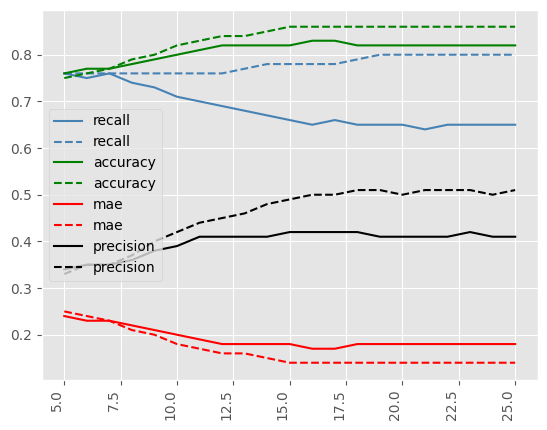

In [63]:
# Plotting 
plt.style.use('ggplot') 

plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.recall_test,'-', c="steelblue", label="recall")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.recall_train,'--', c="steelblue", label="recall")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.accuracy_test,c="green", label="accuracy")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.accuracy_train,'--',c="green", label="accuracy")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.mae_test,c="red", label="mae")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.mae_train,'--',c="red", label="mae")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.precision_test,c="black", label="precision")
plt.plot(metrics_max_depth_df.max_depth, metrics_max_depth_df.precision_train,'--',c="black", label="precision")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.show();

In [64]:

# random forest with different min_leaf
my_leaf_list = []
min_leaf_list = list(np.arange(1, 20))
for i in min_leaf_list:
    my_leaf_list.append(my_random_forest_model(X_train, X_test, y_train, y_test, 100, 8 ,i,0.58, 3.55))

metrics_min_leaf_df = pd.DataFrame(my_leaf_list)
metrics_min_leaf_df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

,cw1,cw0,tree_num,max_depth,min_samples_leaf,accuracy_test,precision_test,recall_test,mae_test,accuracy_train,precision_train,recall_train,mae_train
0,3.55,0.58,100,8,1,0.78,0.36,0.73,0.22,0.79,0.38,0.76,0.21
1,3.55,0.58,100,8,2,0.79,0.37,0.73,0.21,0.79,0.38,0.76,0.21
2,3.55,0.58,100,8,3,0.78,0.36,0.74,0.22,0.78,0.37,0.76,0.22
3,3.55,0.58,100,8,4,0.78,0.37,0.74,0.22,0.79,0.37,0.76,0.21
4,3.55,0.58,100,8,5,0.78,0.36,0.74,0.22,0.79,0.37,0.76,0.21
5,3.55,0.58,100,8,6,0.78,0.37,0.74,0.22,0.79,0.37,0.76,0.21
6,3.55,0.58,100,8,7,0.78,0.37,0.74,0.22,0.78,0.37,0.76,0.22
7,3.55,0.58,100,8,8,0.78,0.36,0.74,0.22,0.78,0.36,0.76,0.22
8,3.55,0.58,100,8,9,0.78,0.36,0.74,0.22,0.78,0.36,0.75,0.22
9,3.55,0.58,100,8,10,0.78,0.36,0.75,0.22,0.78,0.36,0.76,0.22


In [65]:
metrics_min_leaf_df.columns

Index(['cw1', 'cw0', 'tree_num', 'max_depth', 'min_samples_leaf',
       'accuracy_test', 'precision_test', 'recall_test', 'mae_test',
       'accuracy_train', 'precision_train', 'recall_train', 'mae_train'],
      dtype='object')

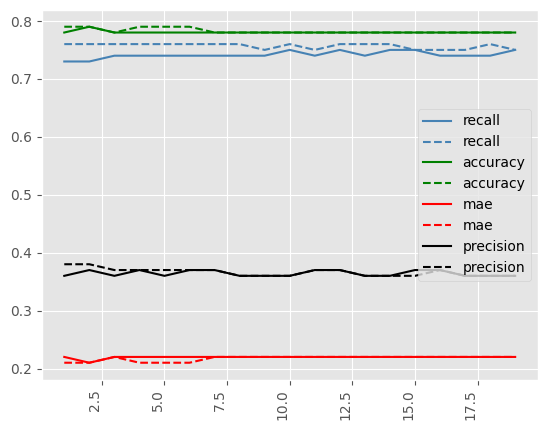

In [66]:
# Plotting 
plt.style.use('ggplot') 

plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.recall_test,'-', c="steelblue", label="recall")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.recall_train,'--', c="steelblue", label="recall")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.accuracy_test,c="green", label="accuracy")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.accuracy_train,'--',c="green", label="accuracy")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.mae_test,c="red", label="mae")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.mae_train,'--',c="red", label="mae")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.precision_test,c="black", label="precision")
plt.plot(metrics_min_leaf_df.min_samples_leaf, metrics_min_leaf_df.precision_train,'--',c="black", label="precision")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.show();

In [67]:
# random forest with different tree number
my_tree_list = []
tree_num_list = list(np.arange(10, 200))
for i in tree_num_list:
    my_tree_list.append(my_random_forest_model(X_train, X_test, y_train, y_test, i, 8 ,10,0.58, 3.55))

metrics_tree_num_df = pd.DataFrame(my_tree_list)
metrics_tree_num_df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

,cw1,cw0,tree_num,max_depth,min_samples_leaf,accuracy_test,precision_test,recall_test,mae_test,accuracy_train,precision_train,recall_train,mae_train
0,3.55,0.58,10,8,10,0.78,0.36,0.76,0.22,0.78,0.37,0.77,0.22
1,3.55,0.58,11,8,10,0.78,0.36,0.76,0.22,0.78,0.36,0.77,0.22
2,3.55,0.58,12,8,10,0.78,0.36,0.76,0.22,0.78,0.36,0.77,0.22
3,3.55,0.58,13,8,10,0.78,0.36,0.76,0.22,0.78,0.36,0.76,0.22
4,3.55,0.58,14,8,10,0.78,0.36,0.76,0.22,0.78,0.36,0.76,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,3.55,0.58,195,8,10,0.78,0.37,0.74,0.22,0.78,0.37,0.75,0.22
186,3.55,0.58,196,8,10,0.78,0.37,0.74,0.22,0.78,0.37,0.75,0.22
187,3.55,0.58,197,8,10,0.78,0.37,0.74,0.22,0.78,0.37,0.75,0.22
188,3.55,0.58,198,8,10,0.78,0.37,0.74,0.22,0.78,0.37,0.75,0.22


In [68]:
metrics_tree_num_df.columns

Index(['cw1', 'cw0', 'tree_num', 'max_depth', 'min_samples_leaf',
       'accuracy_test', 'precision_test', 'recall_test', 'mae_test',
       'accuracy_train', 'precision_train', 'recall_train', 'mae_train'],
      dtype='object')

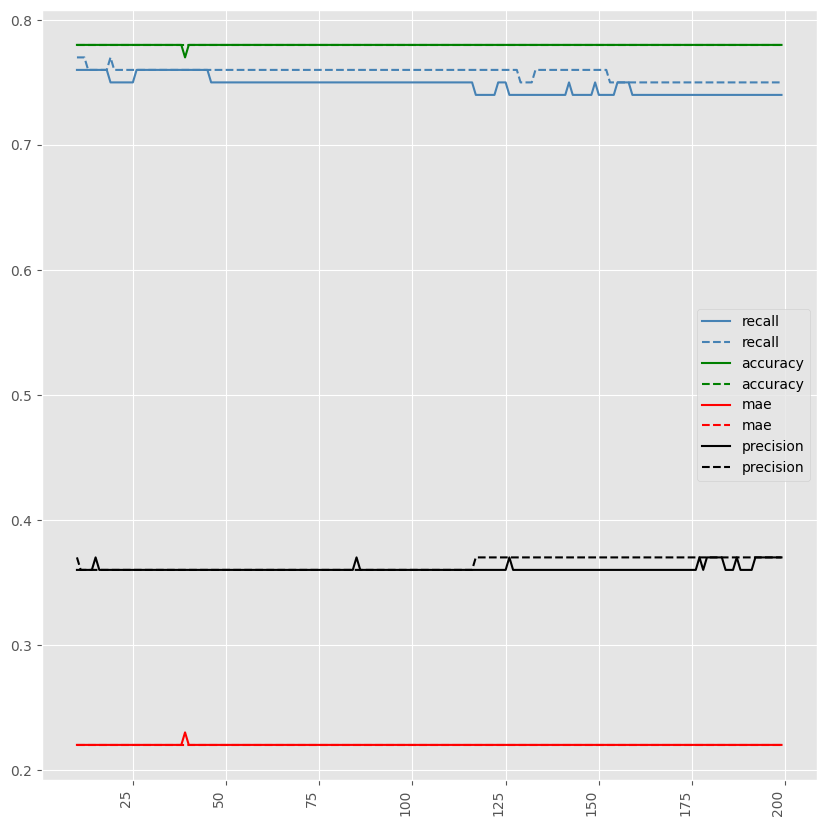

In [69]:
# Plotting 
plt.style.use('ggplot') 
plt.figure(figsize=(10,10))

plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.recall_test,'-', c="steelblue", label="recall")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.recall_train,'--', c="steelblue", label="recall")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.accuracy_test,c="green", label="accuracy")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.accuracy_train,'--',c="green", label="accuracy")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.mae_test,c="red", label="mae")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.mae_train,'--',c="red", label="mae")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.precision_test,c="black", label="precision")
plt.plot(metrics_tree_num_df.tree_num, metrics_tree_num_df.precision_train,'--',c="black", label="precision")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.show();

Random Forest with different number of features  
+ which combination is the best?

In [70]:
# feature List with different combination

feature_list = [['age_of_respondent'], #0
                ['household_size'], #1
                ['education_level'], #2
                ['job_type'], #3
                ['age_of_respondent', 'household_size'], #4
                ['age_of_respondent','education_level'], #5
                ['age_of_respondent','job_type'], #6
                ['household_size','education_level'], #7
                ['household_size', 'job_type'], #8
                ['education_level','job_type'], #9
                ['age_of_respondent', 'household_size','education_level'], #10
                ['age_of_respondent', 'household_size','job_type'], #11
                ['household_size','education_level','job_type'], #12
                ['age_of_respondent', 'household_size','education_level','job_type']] #13

In [71]:
metrics_lst = []

for item in feature_list:
    X_loop = df[item]
    y_loop = df['bank_account']
    # Train-Test-Split
    X_loop_train, X_loop_test, y_loop_train, y_loop_test = train_test_split(X_loop, y_loop,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=y_loop)
    metrics_lst.append(my_random_forest_model(X_loop_train, X_loop_test, y_loop_train, y_loop_test, 50, None, 1, 0.58, 3.55))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

In [72]:
indexing = np.arange(0,len(metrics_lst))
metrics_df = pd.DataFrame(metrics_lst, index=indexing)
metrics_df

,cw1,cw0,tree_num,max_depth,min_samples_leaf,accuracy_test,precision_test,recall_test,mae_test,accuracy_train,precision_train,recall_train,mae_train
0,3.55,0.58,50,None,1,0.43,0.16,0.74,0.57,0.44,0.17,0.78,0.56
1,3.55,0.58,50,None,1,0.59,0.16,0.44,0.41,0.59,0.16,0.46,0.41
2,3.55,0.58,50,None,1,0.77,0.33,0.64,0.23,0.77,0.33,0.61,0.23
3,3.55,0.58,50,None,1,0.84,0.40,0.34,0.16,0.84,0.40,0.34,0.16
4,3.55,0.58,50,None,1,0.56,0.18,0.57,0.44,0.60,0.22,0.70,0.40
5,3.55,0.58,50,None,1,0.78,0.34,0.62,0.22,0.79,0.36,0.64,0.21
6,3.55,0.58,50,None,1,0.70,0.24,0.51,0.30,0.72,0.28,0.60,0.28
7,3.55,0.58,50,None,1,0.77,0.33,0.63,0.23,0.77,0.33,0.61,0.23
8,3.55,0.58,50,None,1,0.75,0.27,0.46,0.25,0.76,0.29,0.49,0.24
9,3.55,0.58,50,None,1,0.80,0.38,0.64,0.20,0.80,0.37,0.62,0.20


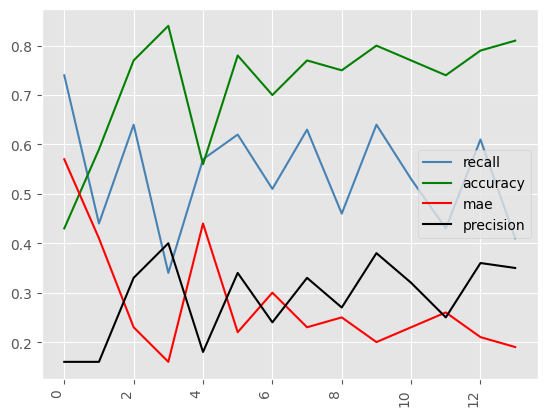

In [73]:
# Plotting 
plt.style.use('ggplot') 

plt.plot(metrics_df.index, metrics_df.recall_test,'-', c="steelblue", label="recall")
#plt.plot(metrics_df.index, metrics_df.recall_train,'--', c="steelblue", label="recall")
plt.plot(metrics_df.index, metrics_df.accuracy_test,c="green", label="accuracy")
#plt.plot(metrics_df.index, metrics_df.accuracy_train,'--',c="green", label="accuracy")
plt.plot(metrics_df.index, metrics_df.mae_test,c="red", label="mae")
#plt.plot(metrics_df.index, metrics_df.mae_train,'--',c="red", label="mae")
plt.plot(metrics_df.index, metrics_df.precision_test,c="black", label="precision")
#plt.plot(metrics_df.index, metrics_df.precision_train,'--',c="black", label="precision")
plt.xticks(rotation=90, ha="right")
plt.legend()


plt.show();

In [74]:
percent_p1 = np.linspace(0.2,0.5, num= 7)
class_weight_lst = []
for i in percent_p1:
    cw1 = round(((i*16466)/2318),2)
    cw0 = round((((1-i)*16466)/14148),2)
    class_weight_lst.append(my_random_forest_model(X_train, X_test, y_train, y_test, 50, 8 ,10, cw0, cw1 ))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_